# Learning to Predict by the Methods of Temporal Differences

## Background

### Theory
observation-outcome sequence: $x_1, x_2, x_3, \ldots, x_m, z$

Prediction: $P\left(x_t, w\right)$

for each sequence, produce prediction $P_1, P_2, P_3, \ldots, P_m$

Update:

$$w \leftarrow w+\sum_{t=1}^m \Delta w_t$$

$\mathrm{TD(1)}$:

$z-P_t=\sum_{k=t}^m\left(P_{k+1}-P_k\right) \quad$ where $\quad P_{m+1} \stackrel{\text { def }}{=} z$

therefore

$$\begin{aligned} w \leftarrow w+\sum_{t=1}^m \alpha\left(z-P_t\right) \nabla_w P_t & =w+\sum_{t=1}^m \alpha \sum_{k=t}^m\left(P_{k+1}-P_k\right) \nabla_w P_t \\ & =w+\sum_{k=1}^m \alpha \sum_{t=1}^k\left(P_{k+1}-P_k\right) \nabla_w P_t \\ & =w+\sum_{t=1}^m \alpha\left(P_{t+1}-P_t\right) \sum_{k=1}^t \nabla_w P_k\end{aligned}$$

or:

$$\Delta w_t=\alpha\left(P_{t+1}-P_t\right) \sum_{k=1}^t \nabla_w P_k$$

$\mathrm{TD(\lambda)}$:

Consider an exponential decayed weighting with recency:

$$\Delta w_t=\alpha\left(P_{t+1}-P_t\right) \sum_{k=1}^t \lambda^{t-k} \nabla_w P_k$$

def: $\quad e_t$ = $\sum_{k=1}^t \lambda^{t-k} \nabla_w P_k$

then: $\quad e_{t+1} = \lambda e_t + \nabla_w P_{t+1}$

### Bounded Random Walk
All walks begin in state $D$. From states $B$, $C, D, E$, and $F$, the walk has a $50-50$ chance of moving either to the right or to the left. If either edge state, $A$ or $G$, is entered, then the walk terminates. We wish to estimate the probabilities of a walk ending in the rightmost state, $G$, given that it is in each of the other states.

![bounded_random_walk.png](https://s2.loli.net/2024/03/20/ri3gvmLDYMKnc2T.png)

- State value function:

    For each non-terminal state $i$, there was a corresponding observation vector $\mathbf{x}_i$; if the walk was in state $i$ at time $t$ then $x_t=\mathbf{x}_i$.

    In this case, the vectors $\left\{\mathbf{x}_i\right\}$ were the **unit basis vectors** of length 5.

    $P_t=w^T x_t = w_i$

## Experiment 1

- $w$ updated only after the **complete** presentation of a training set
- Each training set was presented repeatedly until convergence.

In [54]:
import numpy as np

random_seed = 42
np.random.seed(random_seed)
# start at D
start_pos = 2
# training sets
batch = 100
batch_size = 10
# theoretical probability
P_ideal = np.array([1/6, 1/3, 1/2, 2/3, 5/6])

lambdas = [0, 0.1, 0.3, 0.5, 0.7, 0.9, 1]

def prediction(w, current_pos):
    return w[current_pos]

def state_value(w, current_pos):
    if current_pos == -1:
        return 0
    elif current_pos == 5:
        return 1
    else:
        return prediction(w, current_pos)

def update_weights(w, current_pos, next_pos, alpha, lamb, e):
    delta_w = np.zeros(5)
    delta_e = np.zeros(5)
    delta_e[current_pos] = 1
    e = lamb * e + delta_e
    delta_w = alpha * (state_value(w, next_pos) - state_value(w, current_pos)) * e
    return delta_w, e

### Data generation

In [55]:
def generate_sequence(start_pos = 2):
    current_pos = start_pos
    sequence = [current_pos]
    while True:
        action = np.random.choice([-1,1])
        current_pos += action
        sequence.append(current_pos)
        if current_pos == -1 or current_pos == 5:
            return sequence

def generate_data(batch, batch_size):
    data = []
    for i in range(batch):
        batch_data = []
        for j in range(batch_size):
            batch_data.append(generate_sequence())
        data.append(batch_data)
    return data

data = generate_data(batch, batch_size)

In [61]:
import random
random.sample(data[0], 3)

[[2, 3, 4, 3, 4, 5],
 [2, 1, 0, 1, 2, 3, 4, 5],
 [2, 1, 0, 1, 0, 1, 2, 3, 2, 3, 2, 3, 4, 5]]

In [100]:
import time

def rms_error(batch, w, P_ideal):
    err = 0
    for sequence in batch:
        err_list = []
        for x in sequence[:-1]:
            err_list.append(prediction(w, x) - P_ideal[x])
        err += np.sqrt(np.mean(np.square(err_list)))

    err /= len(batch)

    return err

def train(data, alpha, lamb):
    # init timer
    start = time.time()
    # initialize weights
    w = np.random.uniform(0,1,5)
    err = 0
    for batch in data:

        while True:
            delta_w = np.zeros(5)
            for sequence in batch:
                e = 0
                for idx in range(len(sequence)-1):
                    res =  update_weights(w, sequence[idx], sequence[idx+1], alpha, lamb, e)
                    delta_w += res[0]
                    e = res[1]
            w += delta_w
            if np.linalg.norm(delta_w) < 0.001:
                err += rms_error(batch, w, P_ideal)
                break
    err /= len(data)
    elapsed = round(time.time() - start,3)
    print('Finished training for lambda', lamb, 'in', elapsed, 'seconds')
    return w, err

Finished training for lambda 0 in 3.701 seconds
Finished training for lambda 0.1 in 3.251 seconds
Finished training for lambda 0.3 in 2.94 seconds
Finished training for lambda 0.5 in 2.552 seconds
Finished training for lambda 0.7 in 2.145 seconds
Finished training for lambda 0.9 in 1.719 seconds
Finished training for lambda 1 in 1.809 seconds


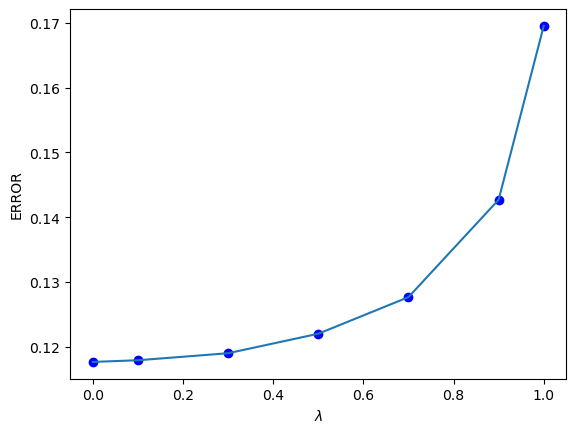

In [101]:
import matplotlib.pyplot as plt

def plot_rms_error(lambdas, alpha, data):
    rms_errors = []
    for lamb in lambdas:
        w,err = train(data, alpha, lamb)
        rms_errors.append(err)
    plt.plot(lambdas, rms_errors)
    plt.xlabel('$\lambda$')
    plt.ylabel('ERROR')
    plt.scatter(lambdas, rms_errors, color='b')
    plt.show()

# learning rate
alpha = 0.01
plot_rms_error(lambdas, alpha, data)

### problems/pitfalls during research
- Trouble understanding when to update $w$ and repeatedly present training sets.
- Need careful selection of (especially)learning rate and convergence conditions!
- WTF is this RMS metric???

## Experiment 2
- same data
- each training set was presented once to each procedure
- weight updates were performed after each sequence
- all components of the weight vector were initially set to $0.5$

In [103]:
lrs = np.linspace(0, 0.6, 13)
lambdas_2 = [0.3, 0.8, 1.0, 0.0]
def train_2(data, alpha, lamb):
    # init timer
    start = time.time()
    # initialize weights to 0.5
    w = np.full(5, 0.5)
    err = 0
    for batch in data:
        for sequence in batch:
            delta_w = np.zeros(5)
            e = 0
            for idx in range(len(sequence)-1):
                res =  update_weights(w, sequence[idx], sequence[idx+1], alpha, lamb, e)
                delta_w += res[0]
                e = res[1]
            w += delta_w
        err += rms_error(batch, w, P_ideal)
    err /= len(data)

    elapsed = round(time.time() - start,3)
    print('Finished training for lambda', lamb, 'at learning rate', alpha, 'in', elapsed, 'seconds')
    return w, err


def plot_rms_error_2(lambdas_2, lrs, data):
    threshold = 0.8
    for lamb in lambdas_2:
        rms_errors = []
        for lr in lrs:
            w,err = train_2(data, lr, lamb)
            if err > threshold:
                break
            rms_errors.append(err)
        plt.plot(lrs[:len(rms_errors)], np.array(rms_errors), label='$\lambda$ = ' + str(lamb))
        plt.scatter(lrs[:len(rms_errors)], np.array(rms_errors))
    plt.legend()
    plt.xlabel('α')
    plt.ylabel('ERROR')
    plt.show()

Finished training for lambda 0.3 at learning rate 0.0 in 0.075 seconds
Finished training for lambda 0.3 at learning rate 0.049999999999999996 in 0.06 seconds
Finished training for lambda 0.3 at learning rate 0.09999999999999999 in 0.056 seconds
Finished training for lambda 0.3 at learning rate 0.15 in 0.057 seconds
Finished training for lambda 0.3 at learning rate 0.19999999999999998 in 0.056 seconds
Finished training for lambda 0.3 at learning rate 0.24999999999999997 in 0.053 seconds
Finished training for lambda 0.3 at learning rate 0.3 in 0.055 seconds
Finished training for lambda 0.3 at learning rate 0.35 in 0.053 seconds
Finished training for lambda 0.3 at learning rate 0.39999999999999997 in 0.051 seconds
Finished training for lambda 0.3 at learning rate 0.44999999999999996 in 0.059 seconds
Finished training for lambda 0.8 at learning rate 0.0 in 0.064 seconds
Finished training for lambda 0.8 at learning rate 0.049999999999999996 in 0.053 seconds
Finished training for lambda 0.8 

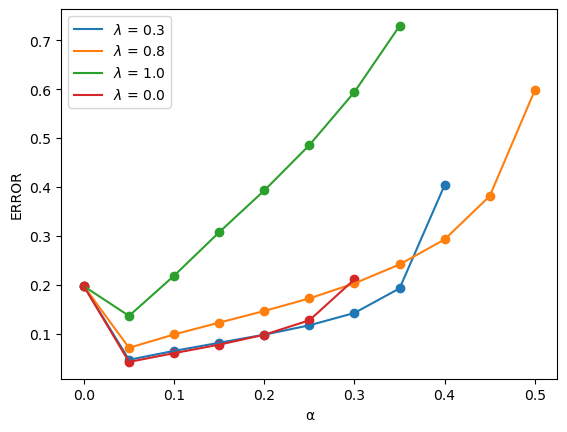

In [104]:
plot_rms_error_2(lambdas_2, lrs, data)